# Next-Frame Video Prediction with Convolutional LSTMs

**Author:** [Amogh Joshi](https://github.com/amogh7joshi)<br>
**Date created:** 2021/06/02<br>
**Last modified:** 2021/06/05<br>
**Description:** How to build and train a convolutional LSTM model for next-frame video prediction.

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-05-25 23:31:01.675756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 23:31:01.698012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:01.724970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:01.725126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 75303299021782965
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5511905280
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14610391688646585116
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:02.036638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:02.036735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 5256 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [3]:
# # Download and load the dataset.
# fpath = keras.utils.get_file(
#     "moving_mnist.npy",
#     "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
# )
# dataset = np.load(fpath)

# # Swap the axes representing the number of frames and number of data samples.
# dataset = np.swapaxes(dataset, 0, 1)
# # We'll pick out 1000 of the 10000 total examples and use those.
# dataset = dataset[:1000, ...]
# # Add a channel dimension since the images are grayscale.
# dataset = np.expand_dims(dataset, axis=-1)

# # Split into train and validation sets using indexing to optimize memory.
# indexes = np.arange(dataset.shape[0])
# np.random.shuffle(indexes)
# train_index = indexes[: int(0.9 * dataset.shape[0])]
# val_index = indexes[int(0.9 * dataset.shape[0]) :]
# train_dataset = dataset[train_index]
# val_dataset = dataset[val_index]

# # Normalize the data to the 0-1 range.
# train_dataset = train_dataset / 255
# val_dataset = val_dataset / 255

# dataset.shape

In [4]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./reformattedData/ConvLSTM_all_cases_80x80_per1000_previousPhi_withTips_zoom_20_compressed.hdf5', mode='r')
dataset = h5.get('phi')

# Split into train and validation sets using indexing to optimize memory.
# indexes = np.arange(dataset.shape[0])
# np.random.shuffle(indexes)
# train_index = indexes[: int(0.9 * dataset.shape[0])]
# val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_index = np.arange(45)
val_index = np.arange(16)+45
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset
val_dataset = val_dataset

dataset.shape

(64, 20, 80, 80, 1)

In [5]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    # y = data[:, 1 : data.shape[1], :, :, 0]

    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (45, 19, 80, 80, 1), (45, 19, 80, 80, 1)
Validation Dataset Shapes: (16, 19, 80, 80, 1), (16, 19, 80, 80, 1)


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 23.


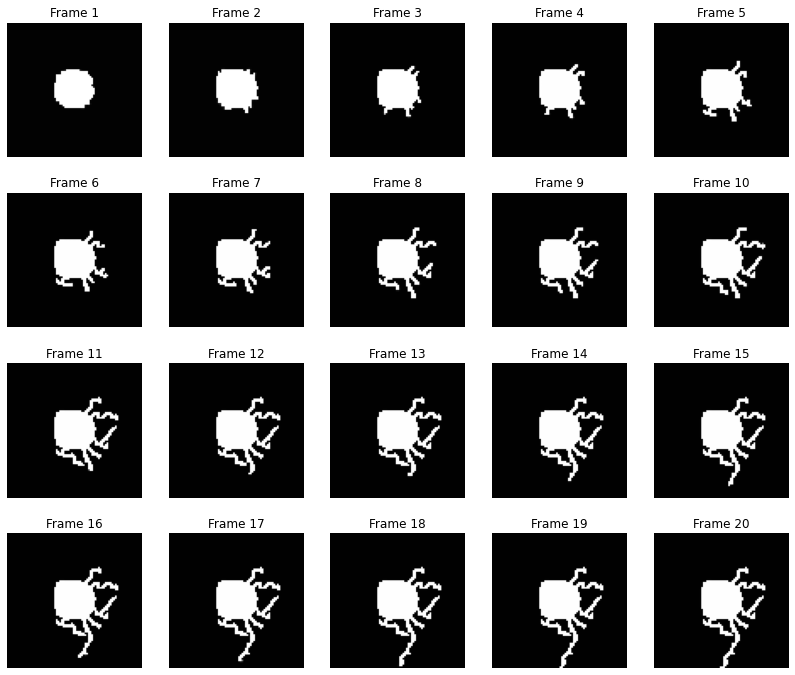

In [6]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(14, 12))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx][:,:,0]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [7]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=256,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(5, 5, 5), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
    # loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), optimizer=keras.optimizers.Adam(),
)

2022-05-25 23:31:03.004188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:03.004365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:03.004466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:03.004738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 23:31:03.004851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## Model Training

With our model and data constructed, we can now train the model.

In [8]:
# Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 1

# with tf.device('/device:CPU:0'):
with tf.device('/device:GPU:0'):

    # Fit the model to the training data.
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        # callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/100


2022-05-25 23:31:05.277818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/input/_1530' -> 'gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/gradient_tape/model/conv_lstm2d_2/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/input/_1649' -> 'gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/gradient_tape/model/conv_lstm2d_1/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_945/input/_1765' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_945/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d_2/while/body/_367/model/conv_lstm2d_2/while/mul_2' -> 'model/con

45/45 [==============================] - ETA: 0s - loss: 0.3845

2022-05-25 23:31:26.443868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/Relu_1' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/mul_5', 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/mul_2' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/add_5', 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/convolution_7' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/add_6'}.


45/45 [==============================] - 25s 466ms/step - loss: 0.3845 - val_loss: 0.4988
Epoch 2/100
45/45 [==============================] - 20s 452ms/step - loss: 0.1128 - val_loss: 0.4720
Epoch 3/100
45/45 [==============================] - 20s 454ms/step - loss: 0.1095 - val_loss: 0.4871
Epoch 4/100
45/45 [==============================] - 20s 455ms/step - loss: 0.1040 - val_loss: 0.5746
Epoch 5/100
45/45 [==============================] - 20s 455ms/step - loss: 0.1021 - val_loss: 0.5752
Epoch 6/100
45/45 [==============================] - 20s 455ms/step - loss: 0.1006 - val_loss: 0.5725
Epoch 7/100
45/45 [==============================] - 21s 457ms/step - loss: 0.0994 - val_loss: 0.5709
Epoch 8/100
45/45 [==============================] - 20s 456ms/step - loss: 0.0972 - val_loss: 0.4792
Epoch 9/100
45/45 [==============================] - 20s 454ms/step - loss: 0.0975 - val_loss: 0.4524
Epoch 10/100
45/45 [==============================] - 20s 455ms/step - loss: 0.0963 - val_loss

In [9]:
model.save('./tmp/model_backup')
# loaded_model = tf.keras.models.load_model('/tmp/model')

2022-05-26 00:05:24.317480: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./tmp/model_backup/assets


In [10]:
# # Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# # Pick the first/last ten frames from the example.
# frames = example[:10, ...]

# test1 = frames[5,:,:,0]
# test2 = frames[5,:,:,1]
# import matplotlib.pyplot as plt
# plt.subplot(1,2,1)
# plt.imshow(test1)
# plt.subplot(1,2,2)
# plt.imshow(test2)

In [11]:
# import matlab.engine

# eng = matlab.engine.start_matlab()
# phi = matlab.double(test1.tolist())
# iter = 20000
# tips_mat = eng.generate_tips_for_python(phi,iter)
# tips = tips_mat.clone() 

# plt.subplot(1,2,1)
# plt.imshow(phi)
# plt.subplot(1,2,2)
# plt.imshow(tips_mat)

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

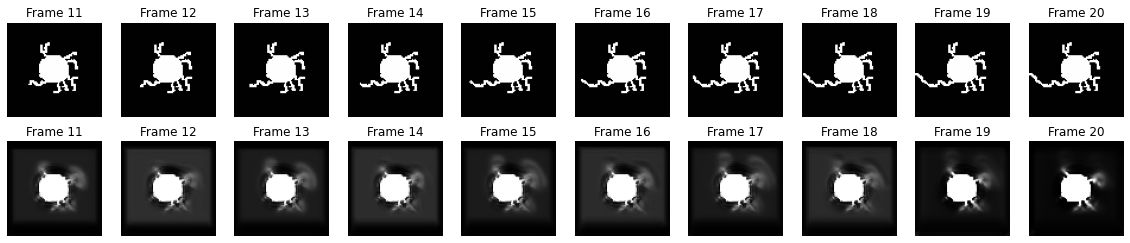

<Figure size 432x288 with 0 Axes>

In [12]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(50):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

plt.savefig('convLSTMresults.png')

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

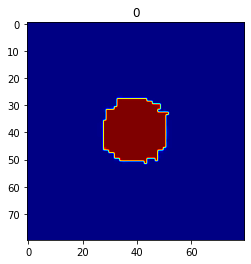

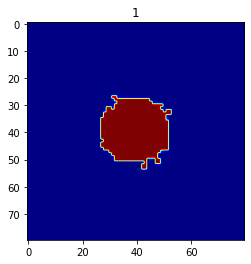

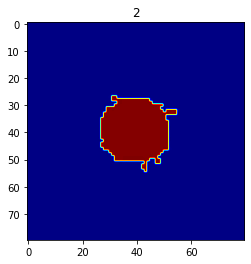

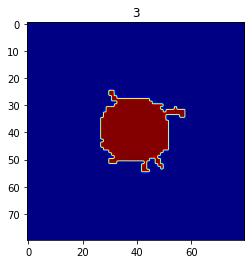

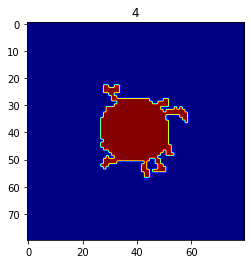

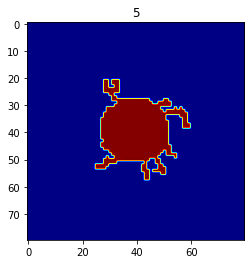

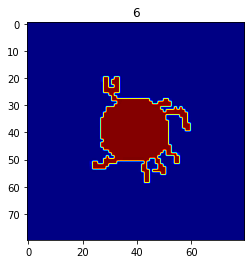

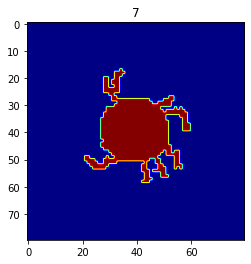

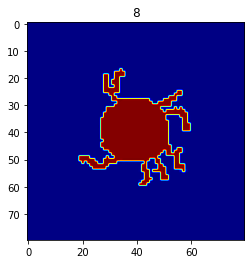

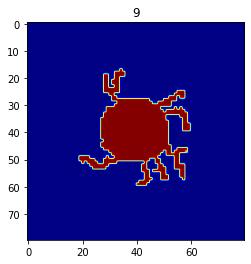

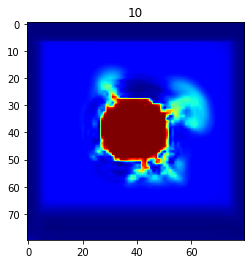

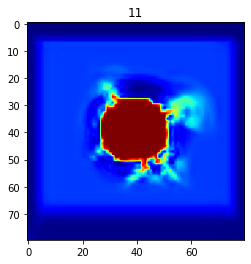

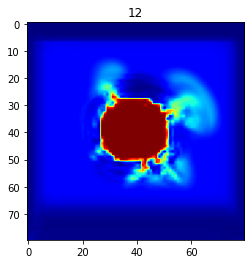

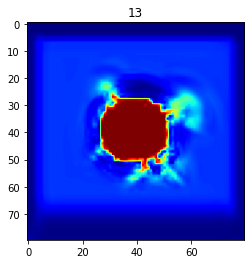

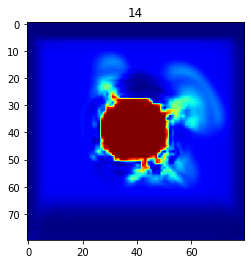

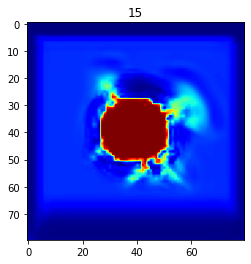

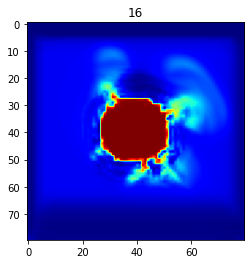

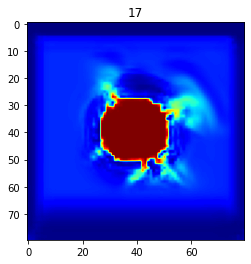

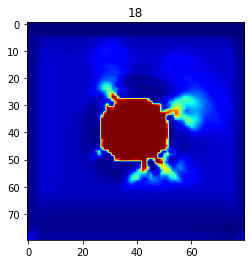

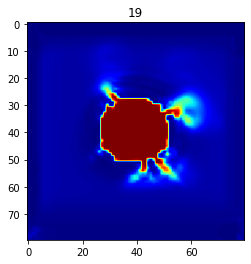

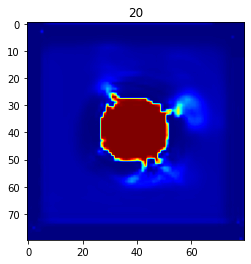

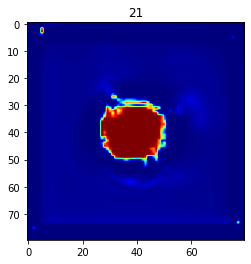

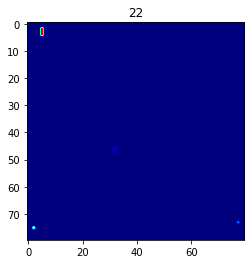

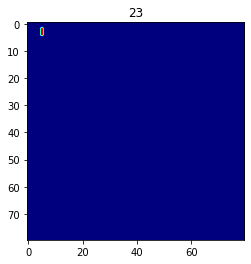

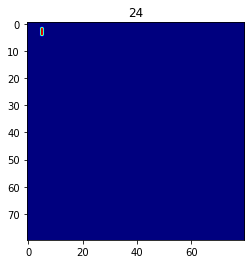

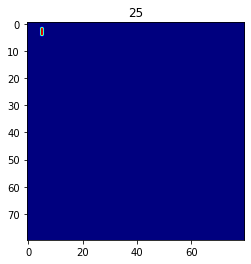

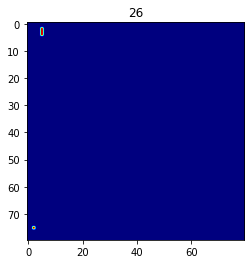

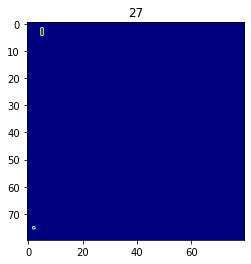

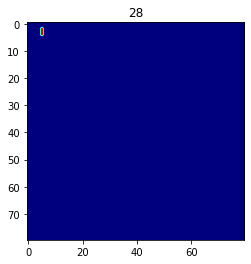

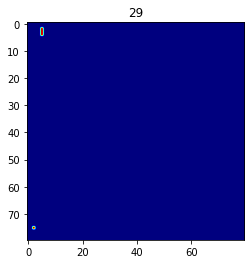

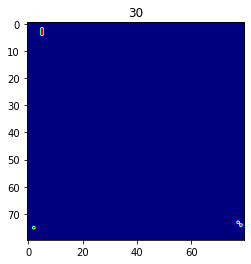

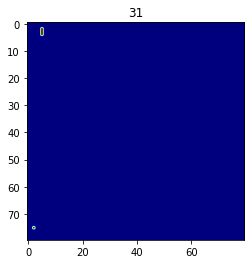

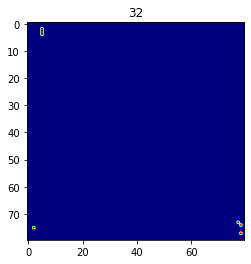

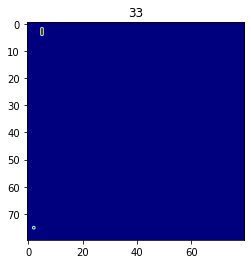

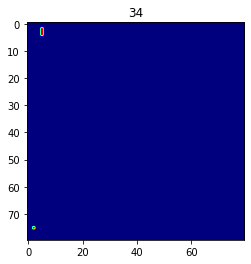

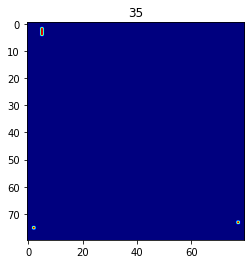

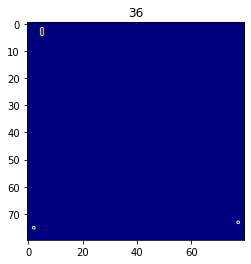

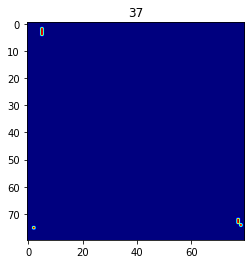

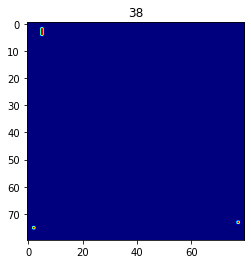

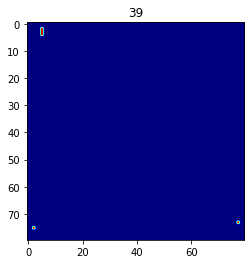

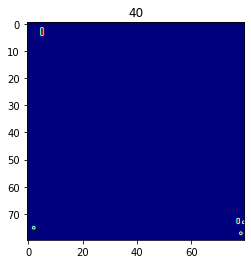

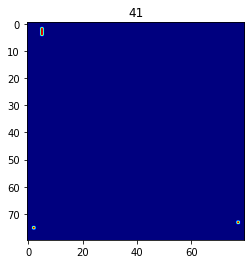

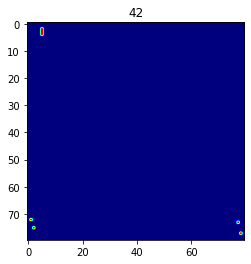

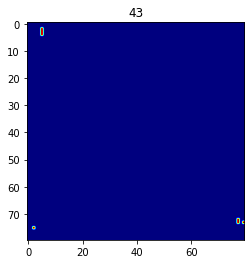

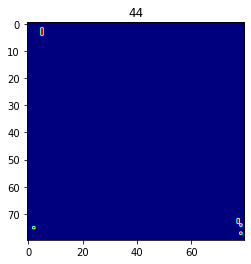

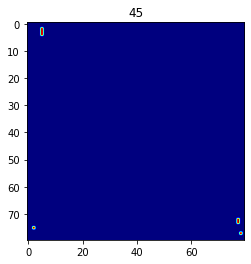

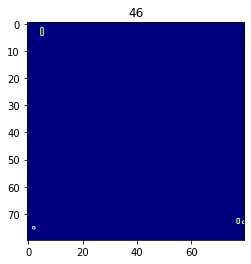

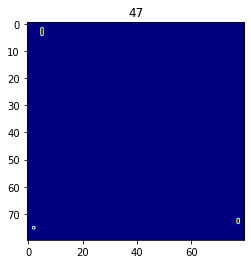

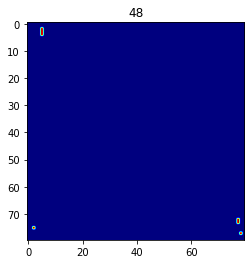

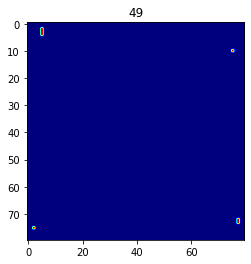

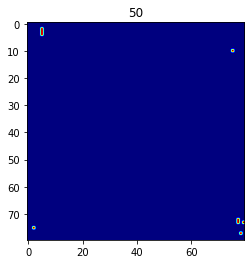

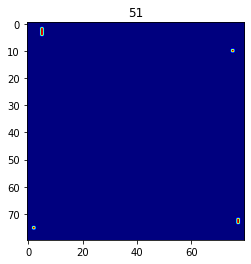

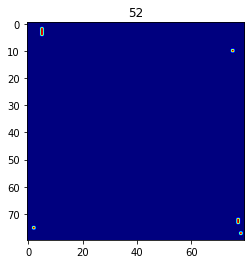

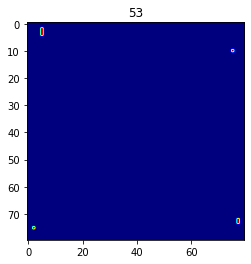

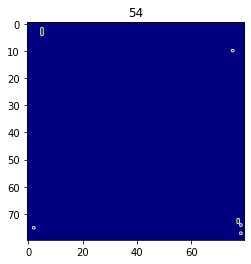

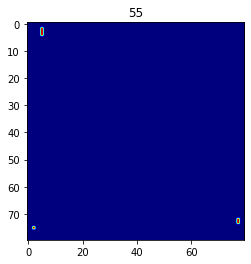

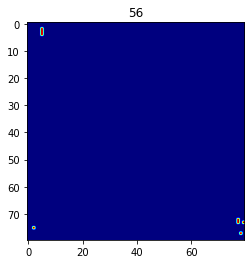

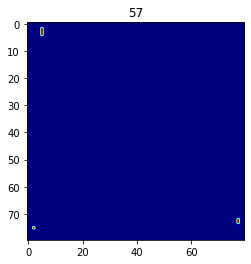

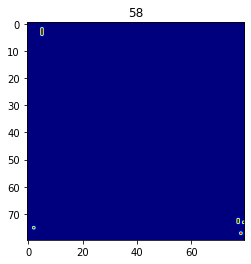

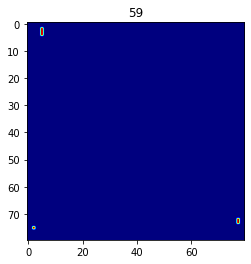

In [13]:
for i in range(len(frames)):
    plt.imshow(np.squeeze(frames[i]), cmap="jet")
    plt.title(i)
    plt.show()
    

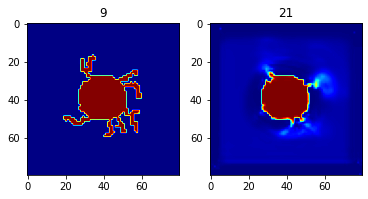

In [14]:
plt.subplot(1,2,1)
plt.imshow(np.squeeze(frames[9]), cmap="jet")
plt.title(9)
plt.subplot(1,2,2)
plt.imshow(np.squeeze(frames[20]), cmap="jet")
plt.title(21)
plt.show()


In [15]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        example[: 10 + i + 2, ...] = predicted_frame

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
